# 11. Using External Models

In this tutorial, we show how to load and use an existing model in a molecular dynamics simulation. Let's import a few packages and then choose our particle number. 

In [1]:
import os

# uncomment to use GPUs
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [8]:
import hoomd
import hoomd.htf as htf
import tensorflow as tf
import hoomd.md
import hoomd.dump
import hoomd.group
import numpy as np
import matplotlib.pyplot as plt
print(htf.__version__)

2.3.0


In [12]:
# number of particles
N = 2**10

We first create a function that maps positions to an image. It does this by doing kernel density estimation in 2D so that pixels are higher valued when more particles are near them. 

In [13]:
def pos2img(positions, low, high, imgw):
    rbf = htf.RBFExpansion(low, high, imgw)
    # histogram in xy dimensions
    x = rbf(positions[...,0])
    y = rbf(positions[...,1])    
    xy = tf.reduce_sum(x[...,None] * y[:,None], 0)
    # now add channel information
    # preprocess -> -1 to 1
    xy -= tf.reduce_mean(xy)
    xy /= tf.math.sqrt(tf.reduce_mean(xy**2))
    # add channels
    img = xy[...,None] * [1., 1., 1.]
    
    return xy

Let's view what this looks like with random particles. The specific size of `224x224` that appears here is because the neural network (mobile net) used below requires images to be in that dimension.

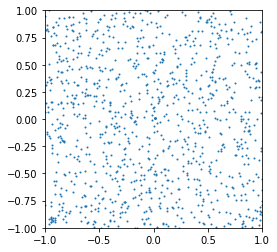

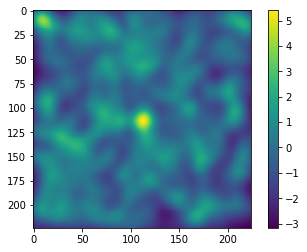

In [14]:
x = np.random.uniform(-1, 1, size=(N, 3))
# make a few dense points
x[0:10, :] = np.random.uniform(0.01, 0.01, size=(10, 3))
x[10:20, :] = np.random.uniform(-0.9, -0.95, size=(10, 3))
i = pos2img(x, -1, 1, 224)
plt.gca().set_aspect('equal')
plt.scatter(x[:,0], x[:,1], s=1)
plt.xlim(-1, 1)
plt.ylim(-1,1)
plt.figure()
plt.gca().set_aspect('equal')
plt.imshow(i.numpy().T, origin='upper', interpolation='none')
plt.colorbar()
plt.show()

Now we'll define our model. Our potential will use similar code to what is above, except we need to create multiple channels because the NN requires channels. We will also do some preprocessing to get the pixel values looking like a standard normal distribution, which again is required for the NN. 

The actual potential energy is the negative log probability of a specific class from the underlying NN. Mobilenet predicts classes from the ImageNet database and so our potential will drive particles to maximize the chosen class. For example, it could drive the simulation to look like a dog or spider web or bulldozer. 

In [15]:
mobilenet = tf.keras.applications.MobileNetV2(classifier_activation=None)

class MobileModel(htf.SimModel):
    def setup(self, low, high, img_shape, target_class):
        self.img_shape = img_shape
        self.rbf = htf.RBFExpansion(low, high, img_shape[0])
        self.target_class = target_class
        self.mean, self.std = None, None
    def compute(self, nlist, positions):
        # histogram in xy dimensions
        x = self.rbf(positions[...,0])
        y = self.rbf(positions[...,1])
        xy = x[...,None] * y[:,None]
        xy = tf.reduce_mean(xy, axis=0)
        img = tf.stack((xy, xy, xy), axis=-1)
        # preprocess -> -1 to 1
        if self.mean is None:
            self.mean = tf.reduce_mean(img)
            self.std = tf.math.sqrt(tf.reduce_mean((img - self.mean)**2))
        img -= self.mean
        img /= self.std
        # get prediction
        logits = mobilenet(img[None])[0]
        energy = -(logits[self.target_class] - tf.reduce_sum(logits))
        forces = htf.compute_positions_forces(positions, energy)     
        return forces, energy, tf.math.softmax(logits)[self.target_class], img, positions

14540800/14536120 [==============================] - 1s 0us/step


Now we set-up the system to be a grid of particles from a lattice.

In [17]:
hoomd.context.initialize('')
sqrt_N = int(np.sqrt(N))
N = sqrt_N**2
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sq(a=0.1),
                                   n=[sqrt_N, sqrt_N])

# add margin for pbc?
L = system.box.Lx / 2 * 0.95
model = MobileModel(0, low=-L, high=L, img_shape=(224, 224, 3),
                   target_class = 134) #134: 'crane', #883 vase #815 spider web #937 broccoli

tfcompute = htf.tfcompute(model)

HOOMD-blue 2.5.2 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 04/30/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 1024 particles


A lattice gives a high energy, since it is far away from looking like a particular image. Thus we first energy minimize to get to a lower potential energy

In [18]:
nve = hoomd.md.integrate.nve(group=hoomd.group.all())
fire=hoomd.md.integrate.mode_minimize_fire(dt=0.01, ftol=1e-5, Etol=1e-9)
tfcompute.attach()
hoomd.run(0)

notice(2): Force mode is FORCE_MODE.tf2hoomd 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): Setting flag indicating virial modification will occur
** starting run **
Time 00:00:04 | Step 0 / 0 | TPS 0 | ETA -2562047:-47:-16
Average TPS: 0
---------
** run complete **


Here is some code to check how our potential energy and temperature are looking. Remember low potential means a high probability of our target class. 

In [19]:
log = hoomd.analyze.log(filename=None, quantities=['potential_energy', 'kinetic_energy', 'temperature'], period=1)

def total_energy(timestep):
    U = log.query('potential_energy')
    TE = log.query('kinetic_energy')
    T = log.query('temperature')
    print('Total energy\t', timestep,'\t', f'{U + TE:.2f}', '\tPotential\t', f'{U:.2f}\tTemperature\t{T:3f}', )
hoomd.analyze.callback(total_energy, 100)

In [20]:
hoomd.run(250)

** starting run **
Total energy	 0 	 -7812.82 	Potential	 -7812.82	Temperature	0.000000
Time 00:00:53 | Step 12 / 250 | TPS 1.15022 | ETA 00:03:26
Time 00:01:03 | Step 24 / 250 | TPS 1.17072 | ETA 00:03:13
Time 00:01:13 | Step 36 / 250 | TPS 1.18075 | ETA 00:03:01
Time 00:01:23 | Step 48 / 250 | TPS 1.17284 | ETA 00:02:52
Time 00:01:34 | Step 60 / 250 | TPS 1.16316 | ETA 00:02:43
Time 00:01:44 | Step 72 / 250 | TPS 1.17958 | ETA 00:02:30
Time 00:01:54 | Step 84 / 250 | TPS 1.16657 | ETA 00:02:22
Time 00:02:04 | Step 96 / 250 | TPS 1.1736 | ETA 00:02:11
Total energy	 100 	 -87519.09 	Potential	 -87545.20	Temperature	0.025525
Time 00:02:15 | Step 108 / 250 | TPS 1.17455 | ETA 00:02:00
Time 00:02:25 | Step 120 / 250 | TPS 1.17813 | ETA 00:01:50
Time 00:02:35 | Step 132 / 250 | TPS 1.17627 | ETA 00:01:40
Time 00:02:45 | Step 144 / 250 | TPS 1.18636 | ETA 00:01:29
Time 00:02:55 | Step 156 / 250 | TPS 1.17691 | ETA 00:01:19
Time 00:03:05 | Step 168 / 250 | TPS 1.18729 | ETA 00:01:09
Time 00:

Now we can run an NVT simulation. 

In [23]:
nve.disable()
nvt = hoomd.md.integrate.langevin(group=hoomd.group.all(), kT=0.01, seed=0)
hoomd.md.integrate.mode_standard(dt=0.005)

*Warning*: Ignoring command to disable an integration method that is already disabled

notice(2): integrate.langevin/bd is using specified gamma values


In [24]:
tfcompute.attach(save_output_period=20)
hoomd.run(400)

notice(2): Force mode is FORCE_MODE.tf2hoomd 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): Setting flag indicating virial modification will occur
** starting run **
Time 00:05:06 | Step 261 / 650 | TPS 1.08523 | ETA 00:05:58
Time 00:05:17 | Step 273 / 650 | TPS 1.17946 | ETA 00:05:19
Time 00:05:27 | Step 285 / 650 | TPS 1.15693 | ETA 00:05:15
Time 00:05:37 | Step 297 / 650 | TPS 1.15444 | ETA 00:05:05
Total energy	 300 	 -195356.61 	Potential	 -195427.64	Temperature	0.069433
Time 00:05:48 | Step 308 / 650 | TPS 1.06883 | ETA 00:05:19
Time 00:05:58 | Step 320 / 650 | TPS 1.18357 | ETA 00:04:38
Time 00:06:08 | Step 332 / 650 | TPS 1.1585 | ETA 00:04:34
Time 00:06:18 | Step 344 / 650 | TPS 1.182 | ETA 00:04:18
Time 00:06:29 | Step 356 / 650 | TPS 1.17866 | ETA 00:04:09
Time 00:06:39 | Step 368 / 650 | TPS 1.19082 | ETA 00:03:56
Time 00:06:49 | Step 380 / 650 | TPS 1.18946 | ETA 00:03:46
Time 00:06:59 | Step 392 / 650 | TPS 1.18352 | ETA 00:03:37
Total 

Let's view how the potential -- probability of the class -- changes over time. 

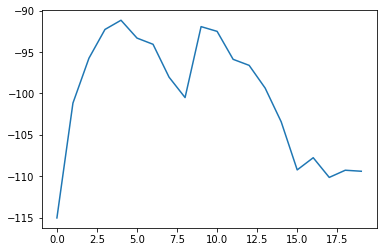

In [25]:
plt.plot(tfcompute.outputs[0])

It decreases some, since we started from an energy minimum. We can also view the probability of the given class. You'll notice the classifier sometimes gives relatively high probabilities that it's looking at the target class. You can experiment with different classes and increasing `N` should improve this agreement.

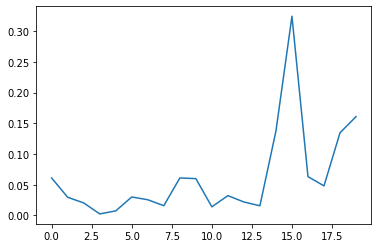

In [26]:
plt.plot(tfcompute.outputs[1])

To look at the generated images, we need to convert from the standard normal pixels to normal pixels that can be plotted. That is what this function does. 

In [27]:
scale = np.max(tfcompute.outputs[-2] , axis=(0,1,2)) - np.min(tfcompute.outputs[-2] , axis=(0,1,2))
processed_outs = (tfcompute.outputs[-2] - np.min(tfcompute.outputs[-2] , axis=(0,1,2))) / scale
print(processed_outs.shape)

(20, 224, 224, 3)


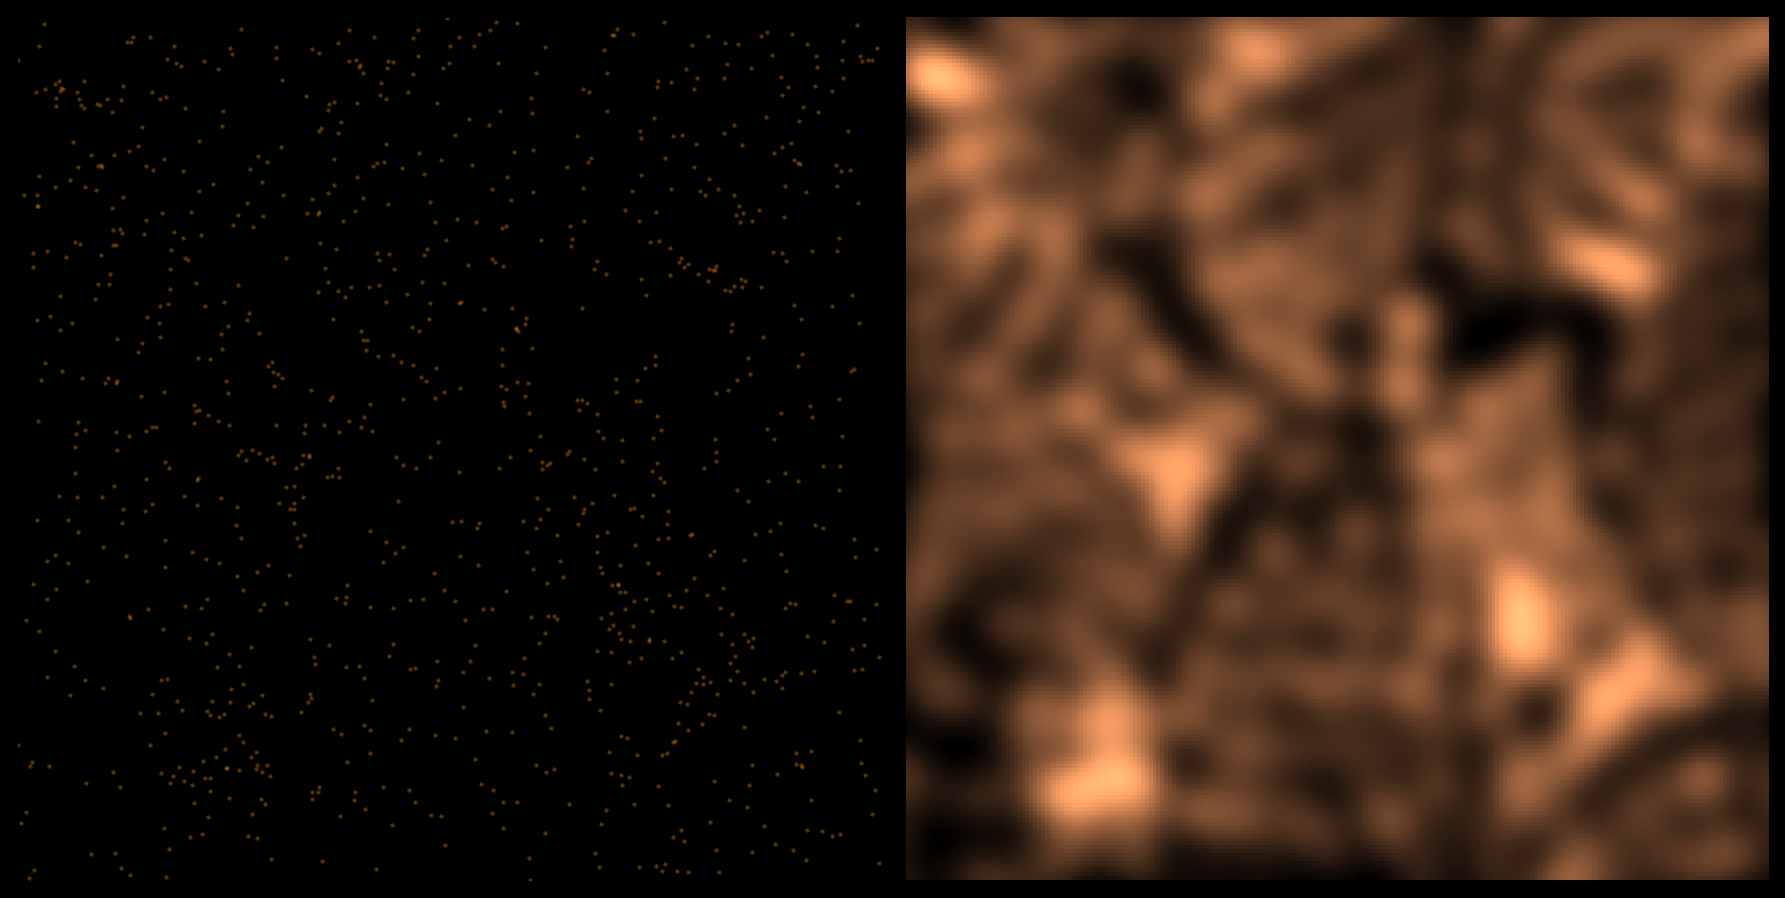

In [30]:
# plot most certain frame
frame = np.argmax(tfcompute.outputs[1])

fig, axs = plt.subplots(ncols=2, figsize=(1920 //180, 1080 // 180), dpi=180, squeeze=2)

scat = axs[0].scatter(tfcompute.outputs[-1][frame,:,0], tfcompute.outputs[-1][frame,:,1], marker='.', s=3, alpha=0.25, color='#f5900a')
ims = axs[1].imshow(processed_outs[frame,...,0].T, interpolation='None', cmap='copper', origin='lower')


axs[0].axis('off')
axs[0].set_aspect('equal')
axs[0].set_xlim(-system.box.Lx / 2, system.box.Lx / 2)
axs[0].set_ylim(-system.box.Ly / 2, system.box.Ly / 2)

axs[1].axis('off')
axs[1].set_aspect('equal')

fig.patch.set_facecolor('black')
fig.tight_layout(pad=1)


You can see this code animated as a [video here](https://twitter.com/andrewwhite01/status/1420010598755094528)